In [2]:
import sys
import shutil
from io import BytesIO
from pathlib import Path
from typing import Tuple, List
import os

import IPython.display
import PIL.Image
from tensorflow.keras.preprocessing import image

import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.measure import block_reduce
from sklearn.metrics import roc_auc_score

from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.models import Sequential, model_from_json
from tensorflow.python.keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [3]:
def load_Mask_files() -> Tuple[List[Path], List[Path]]:
    """
    This function discovers the positive and negative file paths for our task.
    :return: Returns a tuple with the positive and negative paths
    """

    # neg_path = 'SMILEsmileD-master/SMILEs/negatives/negatives7/'  # does not work on all OS

    # works on every OS. Old way using os.path.join()

    # neg_path = os.path.join('SMILEsmileD-master',
    #                         'SMILEs',
    #                         'negatives',
    #                         'negatives7')

    # new way by using pathlib module.
    neg_path = Path.cwd().joinpath('data',
                                   'without_mask')

    print(f"Negative path: {neg_path}")

    # pos_path = 'data/with_mask/'

    pos_path = Path.cwd().joinpath('data',
                                   'with_mask')

    print(f"Positive path: {pos_path}", end='\n\n')

    print('Loading Negative image paths')

    # negative_paths = glob.glob(os.path.join(neg_path, '*.jpg'))
    neg_paths = list(neg_path.glob('*.jpg'))

    print(f'Loaded {len(neg_paths)} Negative image examples', end='\n\n')

    print('Loading Positive image paths')
    # positive_paths = glob.glob(os.path.join(neg_path, '*.jpg'))
    pos_paths = list(pos_path.glob('*.jpg'))

    print(f'Loaded {len(pos_paths)} Positive image examples')

    return neg_paths, pos_paths

In [4]:
def examples_to_dataset(img_paths: List[Path],
                        labels: List[int],
                        block_size: int = 2,
                        as_gray: bool = True):
    """
    This function, given the img_paths loads the images from disk.
    Also, it reduces the images size by under-sampling the pixels


    block_size:
    1: same size.
    2: undersample by 2

    :param img_paths: A list of Paths that define the locations of our images
    :param labels: The labels of our images
    :param block_size: Int. 1 stay unchanged. 2 subsample by 2 etc
    :param as_gray:
    :return:
    """
    assert len(img_paths) == len(labels)

    X = []
    y = []

    for path, label in zip(img_paths, labels):
        # reads the image from the filepath
        img = imread(str(path),
                     as_gray=as_gray)

        # reduces the image size by x times by taking the mean of the pixels.
        img = block_reduce(img,
                           block_size=(block_size,
                                       block_size),
                           func=np.mean)

        X.append(img)

        y.append(label)

    return np.asarray(X), np.asarray(y)

In [7]:
def make_mosaic(images: np.ndarray,
                n=None,
                nx=None,
                ny=None,
                w=None,
                h=None):
    """
    Creates a mosaic of images for demonstration purposes.

    Should work for 1d and 2d images,
    assumes images are square but can be overwritten

    :param images:
    :param n:
    :param nx:
    :param ny:
    :param w:
    :param h:
    :return:
    """

    if n is None and nx is None and ny is None:

        nx, ny = find_rectangle(len(images))

    else:
        nx = n if nx is None else nx
        ny = n if ny is None else ny

    images = np.array(images)

    if images.ndim == 2:  # grey scale. Only one channel

        side = int(np.sqrt(len(images[0])))

        h = side if h is None else h
        w = side if w is None else w

        images = images.reshape(-1, h, w)

    else:
        h = images.shape[1]
        w = images.shape[2]

    image_gen = iter(images)

    mosaic = np.empty((h * ny, w * nx))

    for i in range(ny):

        ia = (i) * h
        ib = (i + 1) * h

        for j in range(nx):
            ja = j * w
            jb = (j + 1) * w

            mosaic[ia:ib, ja:jb] = next(image_gen)

    return mosaic

In [8]:
def show_array(a,
               fmt='png',
               filename=None):
    """

    :param a:
    :param fmt:
    :param filename:
    :return:
    """

    a = np.squeeze(a)
    a = np.uint8(np.clip(a, 0, 255))

    image_data = BytesIO()

    PIL.Image.fromarray(a).save(image_data, fmt)

    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
        plt.show()
    else:

        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

In [9]:
def print_indicator(data,
                    model,
                    class_names,
                    bar_width=50):
    """

    :param data:
    :param model:
    :param class_names:
    :param bar_width:
    :return:
    """

    probabilities = model.predict(np.array([data]), verbose=0)[0]
    
    print(['No_Mask', 'Mask'])
    print(probabilities, end='\n\n')

    left_count = int(probabilities[1] * bar_width)

    right_count = bar_width - left_count

    left_side = '-' * left_count

    right_side = '-' * right_count

    print(f"{class_names[0]} {left_side}###{right_side} {class_names[1]}")

In [10]:
def build_model(
        x,
        n_classes,
        n_filters: int = 32,
        n_pool: int = 2,
        n_conv: int = 3,
        dr: float = 0.25, ):
    """

    :param x:
    :param n_classes:
    :param n_filters:
    :param n_pool:
    :param n_conv:
    :param dr:
    :return:
    """
    assert n_classes == 2

    seq_model = Sequential()

    seq_model.add(Conv2D(n_filters,
                         (n_conv, n_conv),
                         activation='relu',
                         input_shape=x.shape[1:]))

    seq_model.add(Conv2D(n_filters,
                         (n_conv, n_conv),
                         activation='relu'))

    seq_model.add(MaxPooling2D(pool_size=(n_pool,
                                          n_pool)))

    seq_model.add(Dropout(dr))
    seq_model.add(Flatten())

    seq_model.add(Dense(128,
                        activation='relu'))

    seq_model.add(Dropout(dr))

    seq_model.add(Dense(n_classes,
                        activation='softmax'))

    seq_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

    print(seq_model.summary())

    return seq_model

In [11]:
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

In [12]:
# loading from disk the positive and negative paths 
negative_paths, positive_paths = load_Mask_files()

Negative path: /home/vaggelis/PycharmProjects/pythonProject/data/without_mask
Positive path: /home/vaggelis/PycharmProjects/pythonProject/data/with_mask

Loading Negative image paths
Loaded 3349 Negative image examples

Loading Positive image paths
Loaded 3186 Positive image examples


In [13]:
# concatenating all the image paths
image_paths = negative_paths + positive_paths
    
# creating the Y targets for the negative and positive paths
image_labels = [0] * len(negative_paths) + [1] * len(positive_paths)

In [14]:
image_paths

[PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/1108.jpg1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/497.jpg1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/1032.jpgval1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/553.jpg1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/1374.jpg1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/1496.jpg1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/1610.jpg1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/107.jpg1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/1166.jpgval1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask/1341.jpgval1.jpg'),
 PosixPath('/home/vaggelis/PycharmProjects/pythonProject/data/without_mask

In [15]:
image_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [16]:
df1 = pd.DataFrame({'img_paths': image_paths,
              'img_labels': image_labels})
df1

,img_paths,img_labels
0,/home/vaggelis/PycharmProjects/pythonProject/d...,0
1,/home/vaggelis/PycharmProjects/pythonProject/d...,0
2,/home/vaggelis/PycharmProjects/pythonProject/d...,0
3,/home/vaggelis/PycharmProjects/pythonProject/d...,0
4,/home/vaggelis/PycharmProjects/pythonProject/d...,0
...,...,...
6530,/home/vaggelis/PycharmProjects/pythonProject/d...,1
6531,/home/vaggelis/PycharmProjects/pythonProject/d...,1
6532,/home/vaggelis/PycharmProjects/pythonProject/d...,1
6533,/home/vaggelis/PycharmProjects/pythonProject/d...,1


In [17]:
# load the actual images and do some pre-processing to get the X and y datasets
X, y = examples_to_dataset(img_paths=image_paths,
                           labels=image_labels,
                           block_size=2,
                           as_gray=True)

In [18]:
X.shape

(6535, 32, 32)

In [19]:
type(X)

numpy.ndarray

In [20]:
y.shape

(6535,)

In [21]:
# Converting to floats and normalizing the images
X = X.astype(np.float32) / 255.

# Converting the labels to integers
y = y.astype(np.int32)

In [22]:
print(X.dtype, X.min(), X.max(), X.shape)

print(y.dtype, y.min(), y.max(), y.shape)

float32 0.0 1.0 (6535, 32, 32)
int32 0 1 (6535,)


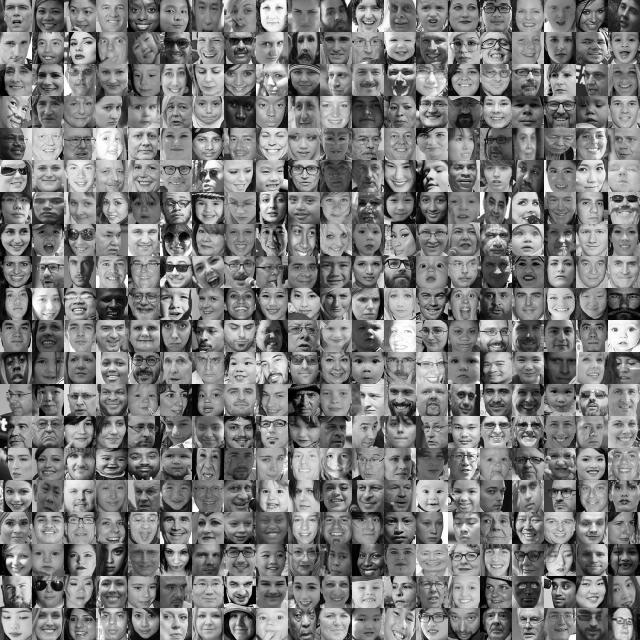

In [23]:
# plot a mosaic of people for the negative paths
show_array(255 * make_mosaic(X[:len(negative_paths)], n=20), fmt='jpeg')  # negative at the beginning

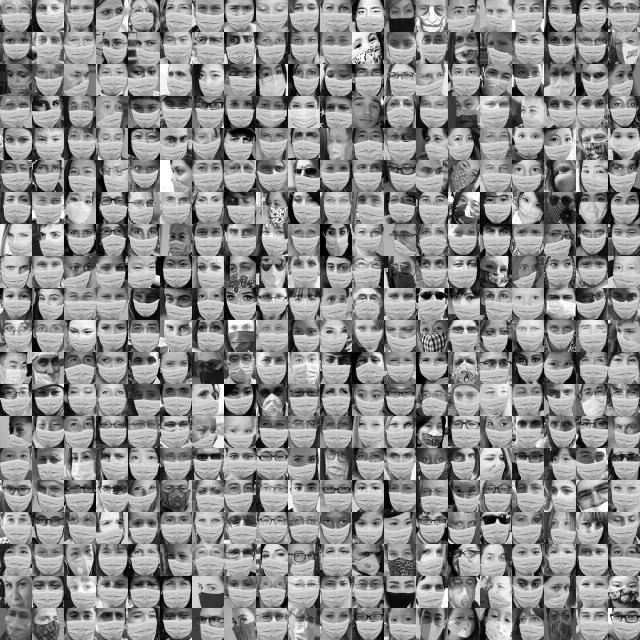

In [24]:
# plot a mosaic of people for the positive (smiling people) paths 
show_array(255 * make_mosaic(X[-len(positive_paths):], n=20), fmt='jpeg')  # positive at the end


In [25]:
# Check out this shape. It doen't contain the "number of channels"
# It's just (n_samples, width, height). 
# We need also the number of channels.|
print(X.shape)

(6535, 32, 32)


In [26]:
# Expanding the dimensions in order to be able to fit it in a CNN model.
X = np.expand_dims(X, axis=-1)

In [27]:
# the new shape 
print(X.shape)

(6535, 32, 32, 1)


In [28]:
# Using numpy to save the X an y's in a special format that is quite easy to store and retrieve
np.save('X.npy', X)
np.save('y.npy', y)

In [29]:
# load the data. We don't need the previous procedure from start
X = np.load('X.npy')
y = np.load('y.npy')

In [31]:
# convert classes to vector
nb_classes = 2

y = np_utils.to_categorical(y, nb_classes).astype(np.float32)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [32]:
# shuffle all the data

# creating indices from the length of X
indices = np.arange(len(X))

# shuffling the indices
np.random.shuffle(indices)

print(f'Getting shuffled indices: {indices}')

# shuffling X and Y
X = X[indices]
y = y[indices]

Getting shuffled indices: [5897 3823 6075 ... 5769 5034 1484]


In [34]:
# prepare weighting for classes since they're unbalanced
class_totals = y.sum(axis=0)
class_weight = class_totals.max() / class_totals

In [35]:
class_weight

array([1.       , 1.0511613], dtype=float32)

In [36]:
print(f'X | Type: {X.dtype}, Min: {X.min()}, Max: {X.max()}, Shape {X.shape}')
print(f'y | Type: {y.dtype}, Min: {y.min()}, Max: {y.max()}, Shape {y.shape}')

X | Type: float32, Min: 0.0, Max: 1.0, Shape (6535, 32, 32, 1)
y | Type: float32, Min: 0.0, Max: 1.0, Shape (6535, 2)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, image_labels, test_size=0.25)

In [38]:
# Setting model hyper-paramters
nb_filters = 64

nb_pool = 2

nb_conv = 3

In [39]:
mask_model = build_model(x=X_train,
                          n_classes=nb_classes,
                          n_filters=nb_filters,
                          n_pool=nb_pool,
                          n_conv=nb_conv,
                          dr=0.25)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [40]:
# Setting hyper-parameters for the fit.

validation_split = 0.10
bs = 64
n_epochs = 100

In [41]:
from tensorflow.python.keras.callbacks import EarlyStopping

# setting the early stoping callback
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1,
                   restore_best_weights=True),

In [42]:
class_weight = {c: w for c, w in enumerate(class_weight)}
class_weight

{0: 1.0, 1: 1.0511613}

In [43]:
mask_model.fit(X_train,
                y_train,
                batch_size=bs,
                class_weight=class_weight,
                epochs=n_epochs,
                verbose=1,
                validation_split=validation_split,
                callbacks=[es[0]])

Epoch 1/100
69/69 [==============================] - 5s 73ms/step - loss: 0.4602 - accuracy: 0.7946 - val_loss: 0.2420 - val_accuracy: 0.9226
Epoch 2/100
69/69 [==============================] - 5s 70ms/step - loss: 0.1605 - accuracy: 0.9474 - val_loss: 0.1382 - val_accuracy: 0.9511
Epoch 3/100
69/69 [==============================] - 5s 71ms/step - loss: 0.0881 - accuracy: 0.9726 - val_loss: 0.1075 - val_accuracy: 0.9572
Epoch 4/100
69/69 [==============================] - 5s 75ms/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 0.0999 - val_accuracy: 0.9613
Epoch 5/100
69/69 [==============================] - 5s 76ms/step - loss: 0.0563 - accuracy: 0.9810 - val_loss: 0.0889 - val_accuracy: 0.9715
Epoch 6/100
69/69 [==============================] - 5s 76ms/step - loss: 0.0447 - accuracy: 0.9848 - val_loss: 0.1042 - val_accuracy: 0.9613
Epoch 7/100
69/69 [==============================] - 5s 77ms/step - loss: 0.0358 - accuracy: 0.9873 - val_loss: 0.0967 - val_accuracy: 0.9715
Epoch 

In [44]:
# saving the model to json format
open('model2.json', 'w').write(mask_model.to_json())

# saving the weights of the model separately
mask_model.save_weights('weights2.h5')

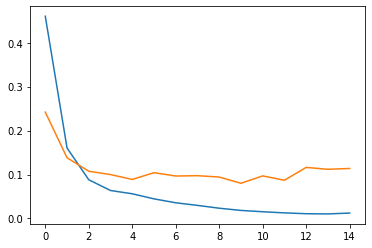

In [45]:
plt.plot(mask_model.history.history['loss'])
plt.plot(mask_model.history.history['val_loss'])
plt.show()

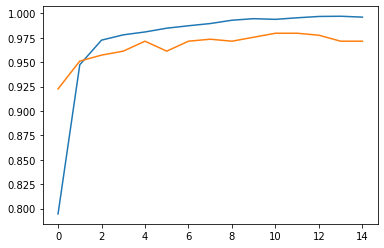

In [46]:
plt.plot(mask_model.history.history['accuracy'])
plt.plot(mask_model.history.history['val_accuracy'])
plt.show()

In [47]:
n_validation = int(len(X_train) * validation_split)

y_predicted = mask_model.predict(X_train[-n_validation:])

print(roc_auc_score(y_train[-n_validation:], y_predicted))

0.9959172790748054


In [48]:
# load the model from json
mask_model = model_from_json(open('model2.json').read())

# loading the weigths
mask_model.load_weights('weights2.h5')

# loading the data (X)
#X = np.load('X.npy')

# creating the class names (0 --> Neutral, 1 --> Smiling)
class_names = ['No mask', 'Mask']

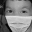

['No_Mask', 'Mask']
[3.4207321e-04 9.9965787e-01]

No mask -------------------------------------------------###- Mask


In [49]:
img = X_test[-36]

show_array(255 * img)

print_indicator(img, mask_model, class_names)

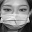

['No_Mask', 'Mask']
[1.3231010e-05 9.9998677e-01]

No mask -------------------------------------------------###- Mask



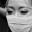

['No_Mask', 'Mask']
[8.739192e-06 9.999913e-01]

No mask -------------------------------------------------###- Mask



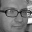

['No_Mask', 'Mask']
[0.66575456 0.33424544]

No mask ----------------###---------------------------------- Mask



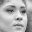

['No_Mask', 'Mask']
[9.9998367e-01 1.6319269e-05]

No mask ###-------------------------------------------------- Mask



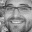

['No_Mask', 'Mask']
[9.9945551e-01 5.4451346e-04]

No mask ###-------------------------------------------------- Mask



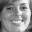

['No_Mask', 'Mask']
[9.993923e-01 6.077535e-04]

No mask ###-------------------------------------------------- Mask



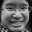

['No_Mask', 'Mask']
[9.999912e-01 8.850465e-06]

No mask ###-------------------------------------------------- Mask



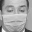

['No_Mask', 'Mask']
[3.5422196e-05 9.9996459e-01]

No mask -------------------------------------------------###- Mask



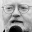

['No_Mask', 'Mask']
[9.9996662e-01 3.3427285e-05]

No mask ###-------------------------------------------------- Mask



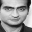

['No_Mask', 'Mask']
[0.9980482  0.00195182]

No mask ###-------------------------------------------------- Mask



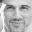

['No_Mask', 'Mask']
[9.9999726e-01 2.7431570e-06]

No mask ###-------------------------------------------------- Mask



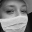

['No_Mask', 'Mask']
[1.695339e-04 9.998305e-01]

No mask -------------------------------------------------###- Mask



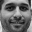

['No_Mask', 'Mask']
[9.9962640e-01 3.7353396e-04]

No mask ###-------------------------------------------------- Mask



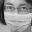

['No_Mask', 'Mask']
[1.1310123e-05 9.9998868e-01]

No mask -------------------------------------------------###- Mask



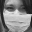

['No_Mask', 'Mask']
[1.1530509e-05 9.9998844e-01]

No mask -------------------------------------------------###- Mask



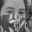

['No_Mask', 'Mask']
[0.00630399 0.99369603]

No mask -------------------------------------------------###- Mask



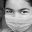

['No_Mask', 'Mask']
[5.0203275e-04 9.9949801e-01]

No mask -------------------------------------------------###- Mask



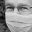

['No_Mask', 'Mask']
[1.11896305e-04 9.99888062e-01]

No mask -------------------------------------------------###- Mask



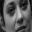

['No_Mask', 'Mask']
[0.8882415  0.11175846]

No mask -----###--------------------------------------------- Mask



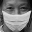

['No_Mask', 'Mask']
[2.2029115e-05 9.9997795e-01]

No mask -------------------------------------------------###- Mask



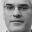

['No_Mask', 'Mask']
[9.9999833e-01 1.6202944e-06]

No mask ###-------------------------------------------------- Mask



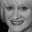

['No_Mask', 'Mask']
[9.9999106e-01 8.9880559e-06]

No mask ###-------------------------------------------------- Mask



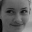

['No_Mask', 'Mask']
[0.99156135 0.00843869]

No mask ###-------------------------------------------------- Mask



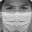

['No_Mask', 'Mask']
[2.0924610e-06 9.9999785e-01]

No mask -------------------------------------------------###- Mask



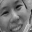

['No_Mask', 'Mask']
[9.991365e-01 8.634996e-04]

No mask ###-------------------------------------------------- Mask



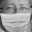

['No_Mask', 'Mask']
[9.253742e-06 9.999907e-01]

No mask -------------------------------------------------###- Mask



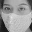

['No_Mask', 'Mask']
[5.626747e-04 9.994373e-01]

No mask -------------------------------------------------###- Mask



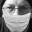

['No_Mask', 'Mask']
[8.6798045e-06 9.9999130e-01]

No mask -------------------------------------------------###- Mask



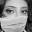

['No_Mask', 'Mask']
[2.7406562e-05 9.9997258e-01]

No mask -------------------------------------------------###- Mask



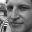

['No_Mask', 'Mask']
[0.9894326  0.01056747]

No mask ###-------------------------------------------------- Mask



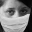

['No_Mask', 'Mask']
[2.0924088e-04 9.9979073e-01]

No mask -------------------------------------------------###- Mask



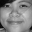

['No_Mask', 'Mask']
[9.997675e-01 2.325163e-04]

No mask ###-------------------------------------------------- Mask



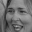

['No_Mask', 'Mask']
[9.9972814e-01 2.7185041e-04]

No mask ###-------------------------------------------------- Mask



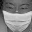

['No_Mask', 'Mask']
[2.0184045e-06 9.9999797e-01]

No mask -------------------------------------------------###- Mask



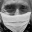

['No_Mask', 'Mask']
[1.3439098e-06 9.9999869e-01]

No mask -------------------------------------------------###- Mask



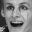

['No_Mask', 'Mask']
[9.9996567e-01 3.4361921e-05]

No mask ###-------------------------------------------------- Mask



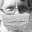

['No_Mask', 'Mask']
[3.4825000e-06 9.9999654e-01]

No mask -------------------------------------------------###- Mask



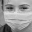

['No_Mask', 'Mask']
[5.8110400e-06 9.9999416e-01]

No mask -------------------------------------------------###- Mask



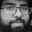

['No_Mask', 'Mask']
[0.9989574  0.00104264]

No mask ###-------------------------------------------------- Mask



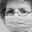

['No_Mask', 'Mask']
[3.5460256e-05 9.9996459e-01]

No mask -------------------------------------------------###- Mask



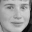

['No_Mask', 'Mask']
[9.9966013e-01 3.3981225e-04]

No mask ###-------------------------------------------------- Mask



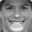

['No_Mask', 'Mask']
[9.9999380e-01 6.1393066e-06]

No mask ###-------------------------------------------------- Mask



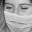

['No_Mask', 'Mask']
[1.05267834e-04 9.99894738e-01]

No mask -------------------------------------------------###- Mask



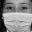

['No_Mask', 'Mask']
[7.7684554e-08 9.9999988e-01]

No mask -------------------------------------------------###- Mask



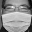

['No_Mask', 'Mask']
[4.2419247e-06 9.9999571e-01]

No mask -------------------------------------------------###- Mask



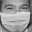

['No_Mask', 'Mask']
[4.7971389e-06 9.9999523e-01]

No mask -------------------------------------------------###- Mask



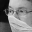

['No_Mask', 'Mask']
[0.0057592 0.9942409]

No mask -------------------------------------------------###- Mask



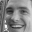

['No_Mask', 'Mask']
[9.9984539e-01 1.5462973e-04]

No mask ###-------------------------------------------------- Mask



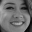

['No_Mask', 'Mask']
[9.999614e-01 3.861501e-05]

No mask ###-------------------------------------------------- Mask



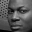

['No_Mask', 'Mask']
[9.999994e-01 5.500323e-07]

No mask ###-------------------------------------------------- Mask



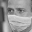

['No_Mask', 'Mask']
[3.1738260e-04 9.9968266e-01]

No mask -------------------------------------------------###- Mask



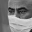

['No_Mask', 'Mask']
[1.6544813e-05 9.9998343e-01]

No mask -------------------------------------------------###- Mask



In [51]:
for i in range(0, len(X_test), int(len(X_test)/50)):

    img = X_test[i]


    show_array(255 * img)
    print_indicator(img, mask_model, class_names)
    
    print()

In [52]:
y_score = mask_model.predict(X_test)

In [54]:
predicted_labels = []
for p in y_score:
    predicted_labels.append(0) if p[0] <= 0.5 else predicted_labels.append(1)

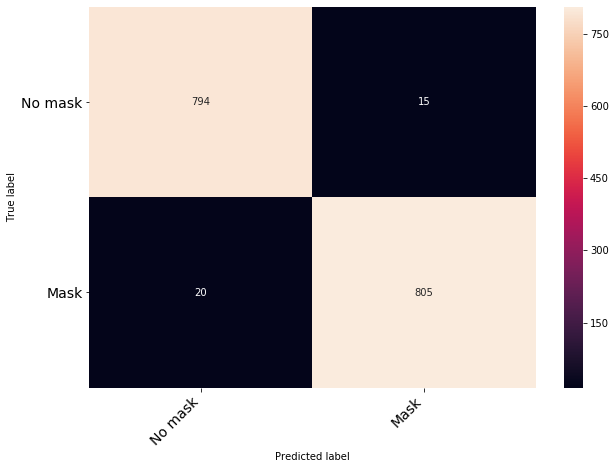

,No mask,Mask
No mask,794,15
Mask,20,805


In [66]:
print_confusion_matrix(y_true=y_test[:,0],
                           y_pred=predicted_labels,
                      class_names = class_names)
                       
                           

In [62]:
conf_matrix = confusion_matrix(y_true=y_test[:,0], y_pred=predicted_labels)

In [63]:
conf_matrix 

array([[794,  15],
       [ 20, 805]])